In [ ]:
# Imports
import os
import pickle
import numpy as np
import torch 
import csv
from torch import nn 
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets, transforms
import tensorflow
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt

# from missingpy import MissForest

In [ ]:
# Mount Google Drive to access Zip
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip Data
!unzip /content/gdrive/MyDrive/package-plco-1161.2023-03-02.zip > /dev/null

replace userguide.PLCO.d053122.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load the CSV file
!unzip Colorectal/colo_data_mar22_d032222.csv.zip > /dev/null

replace colo_data_mar22_d032222.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load Data
with open('colo_data_mar22_d032222.csv') as csvfile:
    dataset = pd.read_csv(csvfile) 

    # Remove patients that never had a colon cancer diagnosis: 
    no_canc_idxs = dataset[dataset['colo_cancer'] == 0].index 
    dataset.drop(no_canc_idxs, inplace=True)

    # Remove outcome features from dataset 
    dataset.pop('is_dead')
    dataset.pop('is_dead_with_cod') 
    dataset.pop('mortality_exitdays') 
    dataset.pop('dth_days')  
    # Death cert data
    dataset.pop('d_seer_death') #Death cert cause of death 
    dataset.pop('d_cancersite')
    dataset.pop('d_codeath_cat')
    dataset.pop('d_dthc')
    # Cause of death
    dataset.pop('f_seer_death') # final underlying cause of death
    dataset.pop('f_cancersite')
    dataset.pop('f_codeath_cat')
    dataset.pop('f_dthc')

    # Removing identifiers from study that we don't need 
    dataset.pop('plco_id')
    dataset.pop('build')
    dataset.pop('build_cancers')
    dataset.pop('build_death_cutoff')
    dataset.pop('build_incidence_cutoff')

    # Removing unrelated elligibility features from the dataset (leave in age at entry and prior history of cancer)
    dataset.pop('entrydays_bq') # Days from date of radomisation until the participant has been radomised
    dataset.pop('entrydays_dhq')
    dataset.pop('entrydays_dqx')
    dataset.pop('entrydays_sqx')
    dataset.pop('entrydays_muq')

    # Removing unrealted features related to consent forms
    dataset.pop('dual')
    dataset.pop('reconsent_outcome')
    dataset.pop('reconsent_outcome_days')

    # Removing unrelated cancer diagnosis features (reasons for visits)
    dataset.pop('reasfollc') # Followup pos screen
    dataset.pop('reasothc') # Other
    dataset.pop('reassurvc') # Surveillance
    dataset.pop('reassympc') # Symptomatic

    # Convert categorical "colo_topography" features to numeric format
    dataset['colo_topography']= dataset['colo_topography'].replace('C180', .180)
    dataset['colo_topography']= dataset['colo_topography'].replace('C182', .182)
    dataset['colo_topography']= dataset['colo_topography'].replace('C183', .183)
    dataset['colo_topography']= dataset['colo_topography'].replace('C184', .184)
    dataset['colo_topography']= dataset['colo_topography'].replace('C185', .185)
    dataset['colo_topography']= dataset['colo_topography'].replace('C186', .186)
    dataset['colo_topography']= dataset['colo_topography'].replace('C187', .187)
    dataset['colo_topography']= dataset['colo_topography'].replace('C188', .188)
    dataset['colo_topography']= dataset['colo_topography'].replace('C189', .189)
    dataset['colo_topography']= dataset['colo_topography'].replace('C199', .199)
    dataset['colo_topography']= dataset['colo_topography'].replace('C209', .209)
    dataset['colo_topography']= dataset['colo_topography'].replace('C212', .212)
    dataset['colo_topography']= dataset['colo_topography'].replace('C218', .218)

    # Removing unrelated pathology imaging number features
    dataset.pop('adenoma_has_deliv_heslide_img')
    dataset.pop('colo_has_deliv_heslide_img')
    dataset.pop('adenoma_num_heslide_imgs')
    dataset.pop('colo_num_heslide_imgs')

    # Remove unrelated features about study form compliance
    dataset.pop('bq_returned')
    dataset.pop('bq_compdays')
    dataset.pop('bq_adminm')

    # Remove features about study entry and exit 
    dataset.pop('colo_exitstat')
    dataset.pop('fstcan_exitstat')
    dataset.pop('colo_exitdays')
    dataset.pop('fstcan_exitdays')
    dataset.pop('mortality_exitstat')
    dataset.pop('mortality_exitage')

    # Remove features about study elligibility
    dataset.pop('colo_eligible_sqx')
    dataset.pop('colo_eligible_bq')
    dataset.pop('colo_eligible_dqx')
    dataset.pop('colo_eligible_dhq')
    dataset.pop('arm')

    # If Adenoma finding is empty make it 0
    dataset['aden_count_eith35'].fillna(0)

    # Remove patients who have fewer than 100 feature values(ie missing too much data)
    dataset = dataset.dropna(thresh=100)   

    # Remove features from the dataset that have NaN values for more than 3/4 of remaining patients
    for column in dataset.columns:
        # Calculate the percentage of NaN values in the column
        percent_missing = dataset[column].isna().sum() / len(dataset)
        if percent_missing > .50:
            dataset.pop(column)

    # Extract first row, which is list of features recorded (remaining)
    list_of_features = []
    for row in dataset:
      list_of_features.append(row)
      
# Create Attribute Dictionary 
attr_dict = {"patient" : "outcome"}
with open('colo_data_mar22_d032222.csv') as csvfile:
  cocdata_dictreader = csv.DictReader(csvfile)
  patient_number = 0 
  for row in cocdata_dictreader:
   
    # Survived 
    if row['colo_exitstat'] == '8':
      attr_dict[patient_number] =  0 # cancer-free 
    
    # Died
    if row['is_dead'] == '1':

      # Determine Time To Death 
      if int(row['mortality_exitdays']) < 365: # under 1 year
        attr_dict[patient_number] = 1

      if 365 < int(row['mortality_exitdays']) < 365*3: # 1-3 years 
        attr_dict[patient_number] = 2
    
      if 365*3 < int(row['mortality_exitdays']) < 365*5: # 3-5 years
        attr_dict[patient_number] = 3
     
      if 365*5 < int(row['mortality_exitdays']) < 365*7: # 5-7 years 
        attr_dict[patient_number] = 4 
     
      if 365*7 < int(row['mortality_exitdays']) < 365*10: # 7-10 years
        attr_dict[patient_number] = 5 
      
      if 365*10 < int(row['mortality_exitdays']) < 365*12: # 10-12 years 
        attr_dict[patient_number] = 6
      
      if 12*365 < int(row['mortality_exitdays']):  #12+ years 
        attr_dict[patient_number] = 7 

    # If entry empty, update to next patient without adding anything to dictionary 
    else: 
      patient_number += 1
    
    # Update count to next patient
    patient_number += 1

In [ ]:
# # MissForest Impuation for missing values:
# imputer = MissForest()
# imputer.fit(dataset)

# # Impute missing values in test data
# imputed_dataset = imputer.transform(dataset)

# Scale data
from sklearn.preprocessing import MinMaxScaler
# Create scaler object
scaler = MinMaxScaler()

# Normalize data
norm_dataset = pd.DataFrame(scaler.fit_transform(dataset.values), columns=dataset.columns, index=dataset.index)
dataset = norm_dataset

# Mean impute missing dat
means = dataset.mean(axis=0)
dataset.fillna(means, inplace = True)

# Replace Nan values with 0
# dataset.fillna(0, inplace = True)

In [ ]:
print(list_of_features)
print(len(list_of_features))

['num_cancc', 'colo_cancer', 'colo_icdO2_tmrloc', 'intstatc_cat', 'colo_appendix_cancer', 'colo_stage', 'colo_stage_7e', 'colo_stage_t', 'colo_stage_n', 'colo_stage_m', 'colo_pathstage', 'colo_pathstage_7e', 'colo_pathstage_t', 'colo_pathstage_n', 'colo_pathstage_m', 'colo_cancer_type', 'colo_location', 'colo_location_side', 'colo_location_summary', 'colo_location_rectum', 'colo_topography', 'colo_grade', 'colo_morphology', 'colo_behavior', 'curative_resectc', 'curative_radc', 'curative_chemoc', 'neoadjuvantc', 'primary_trtc', 'colo_exitage', 'colo_cancer_first', 'colo_seer', 'colo_annyr', 'primary_trtc_days', 'colo_cancer_diagdays', 'colo_mra_stat0', 'colo_mra_stat3', 'colo_mra_stat5', 'colo_mra_stat35', 'iaden_exclusion', 'educat', 'marital', 'occupat', 'pipe', 'cigar', 'sisters', 'brothers', 'asp', 'ibup', 'stool_history', 'colorect_history', 'asppd', 'ibuppd', 'hyperten_f', 'hearta_f', 'stroke_f', 'emphys_f', 'bronchit_f', 'diabetes_f', 'polyps_f', 'arthrit_f', 'osteopor_f', 'diver

In [ ]:
print(type(attr_dict))
print(type(dataset))

In [ ]:
# Create samples 
patient_number = 0 
samples = []

for row in range(len(dataset)):
  patient_features = dataset.iloc[row]
  patient_features = patient_features.values.astype(np.float32)
  
  if patient_number in attr_dict: # make sure we have an outcome for the patient
      label = attr_dict[patient_number]
      label = np.int64(label)
      samples.append((patient_features, label))    
  patient_number += 1

samples = np.array(samples, dtype=object)

In [ ]:
# Randomly subsample the survived group to reduce the size of the category
print("Starting Lengths Samples:" , len(samples))
zero_class_all = []
zero_class_idxs = []
for i in range(len(samples)): 
  sample = samples[i]
  if sample[1] == 0:
    zero_class_all.append(sample)
    zero_class_idxs.append(i)

samples = np.delete(samples, zero_class_idxs, 0)
print("Lengths Samples Without Zero Class", len(samples))
print("Length Zero Class Array:", len(zero_class_all))


import random
zero_class_subsample = random.sample(zero_class_all, 200)
zero_class_subsample = np.array(zero_class_subsample, dtype =object)
samples = np.concatenate((samples, zero_class_subsample), 0)
print("Final Length Samples", len(samples))

samples = np.array(samples, dtype=object)

Starting Lengths Samples: 1356
Lengths Samples Without Zero Class 540
Length Zero Class Array: 816
Final Length Samples 740


In [ ]:
# okay so "samples" is the list of all the tuples, "sample" is an individual tuple where 
# "sample[0]" is the np.array of features where each feature is a float and "sample[1]" is 
# the outcome which is an int

print("Total Patients:", len(samples)) # Number of patients
print("Total Patient Features:", len(sample[0])) # Number of features associated with each patient

# Find Number of patients in each class 
count_0 = 0 
count_1 = 0 
count_2 = 0 
count_3 = 0 
count_4 = 0 
count_5 = 0 
count_6 = 0 
count_7 = 0 
count_8 = 0 

for i in range(len(samples)):
    sample = samples[i]
    if sample[1] == 0:
      count_0 += 1 
    if sample[1] == 1:
      count_1 += 1 
    if sample[1] == 2:
      count_2 += 1 
    if sample[1] == 3:
      count_3 += 1 
    if sample[1] == 4:
      count_4 += 1 
    if sample[1] == 5:
      count_5 += 1 
    if sample[1] == 6:
      count_6 += 1 
    if sample[1] == 7:
      count_7 += 1
    if sample[1] == 8:
      count_8 += 1 

print("Number of class 0:", count_0)    
print("Number of class 1:", count_1)     
print("Number of class 2:", count_2)     
print("Number of class 3:", count_3)     
print("Number of class 4:", count_4)     
print("Number of class 5:", count_5)     
print("Number of class 6:", count_6)    
print("Number of class 7:", count_7)     
# print("Number of class 8:", count_8)  

# Define class weights
class_weights = 1 / np.array([count_0, count_1, count_2, count_3, count_4, count_5, count_6, count_7])
class_weights = class_weights / np.sum(class_weights)
print(class_weights)

Total Patients: 1355
Total Patient Features: 119
Number of class 0: 815
Number of class 1: 7
Number of class 2: 27
Number of class 3: 29
Number of class 4: 37
Number of class 5: 71
Number of class 6: 54
Number of class 7: 315
[0.00440717 0.51312046 0.13303123 0.12385666 0.09707684 0.05058934
 0.06651562 0.01140268]


In [ ]:
# Data Loader
class ColorectalCancerDataset(Dataset):
    def __init__(self, sample_data, transform, shuffle=True):
        self.sample_data = sample_data
        self.transform = transform 
        self.shuffle = shuffle

    def __len__(self):
        return len(self.sample_data)

    def __getitem__(self, idx):
        patient_features, label = self.sample_data[idx]
           
        if self.transform is not None:
          patient_features = torch.from_numpy(patient_features)
          label = torch.tensor(label, dtype=torch.int64)
    
        return patient_features, label

In [ ]:
# Load  train and test datasets using the data loader and split randomly
loaded_data = ColorectalCancerDataset(samples, transform=not None, shuffle=True) 
train_data, test_data = random_split(loaded_data,[.8, .2])

In [ ]:
# Split up the samples equally by class: 
class_counts = {i: 1 for i in range(8)}
for features, label in samples:
    class_counts[label] += 1

# Calculate the number of samples (80%) to include in the training set for each class
train_counts = {i: int(0.8* count) for i, count in class_counts.items()}

# Initialize dictionaries to store the samples for each class
train_samples = {i: [] for i in range(8)}
test_samples = {i: [] for i in range(8)}

# Split the samples into train and test sets for each class
for features, label in samples:
    if len(train_samples[label]) < train_counts[label]:
        train_samples[label].append((features, label))
    else:
        test_samples[label].append((features, label))

# Concatenate the samples for all classes into a single list
train_samples = sum(train_samples.values(), [])
test_samples = sum(test_samples.values(), [])

In [ ]:
# Load the train and test datasets with equal distribution of classes using the dataloader
train_data = ColorectalCancerDataset(train_samples, transform=not None, shuffle=True) 
test_data = ColorectalCancerDataset(test_samples, transform=not None, shuffle=True)

In [ ]:
# PRINT TO TEST DATA LOADING
for i in range(len(train_data)):
    sample = train_data[i]
    for value in sample: 
        print(value)
    if i == 1: 
       break

print(type(train_data))
for batch in train_data: 
  x, y = batch
  print("batch type is:",type(batch))
  print("x type is:", type(x))
  print("y type is:", type(y))
  break

In [ ]:
# Figure out the sizes of the data loaded in
for batch in train_data: 
  x, y = batch
  print(x.shape)
  print(y.shape)
  break

torch.Size([118])
torch.Size([])


In [ ]:
# Define Model: 
class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(118, 64) # affine layer: input is a the feature array
    self.l2 = nn.Linear(64, 32)
    self.l3 = nn.Linear(32, 8) # output size is 8 (classes 0 - 7)
    self.do = nn.Dropout(0.1)

  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    do = self.do(h2) # Dropout Value --> makes residual connection (improves speed of training)
    logits = self.l3(do) 
    return logits

model = ResNet() 

# Define Optimiser 
params = model.parameters() 
optimiser = optim.SGD(params, lr=1e-2) 

# Define Loss (objective function)
loss = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float()) #weight=torch.from_numpy(class_weights).float()

In [ ]:
# Training Loop
epochs = 5 # Number of loops through data set 

for epoch in range(epochs):
  losses = list() 
  accuracies = list()
  model.train() # Needed since using dropout
  for batch in train_data: 
    x, y =  batch #(x is input (features) and y is label)    


# SUPERVISED LEARNING: 
    # Step 1: Forward 
    l = model(x) #logits 

    # Step 2: Compute Objective Function 
    J = loss(l, y) 

    # Step 3: Clean the Gradient --> necessary for computing gradients 
    model.zero_grad() 

    # Step 4: Accumulate Partial Derivatives of J (with respect to parameters)
    J.backward()

    # Step 5: Step (in opposite direction of gradient)
    optimiser.step() 

    losses.append(J.item())
    accuracies.append(y.eq(l.detach().argmax().cpu()).float().mean())
    
  
  print(f'Epoch {epoch + 1}: Training Loss = {torch.tensor(losses).mean():.2f}, Accuracy = {torch.tensor(accuracies).mean():.2f}')


Epoch 1: Training Loss = 0.56, Accuracy = 0.84
Epoch 2: Training Loss = 0.61, Accuracy = 0.80
Epoch 3: Training Loss = 0.62, Accuracy = 0.80
Epoch 4: Training Loss = 0.61, Accuracy = 0.82
Epoch 5: Training Loss = 0.61, Accuracy = 0.83


In [ ]:
# Validation Loops
losses = list()
accuracies = list() 
model.eval() # Set model evaluation mode since dropout is sensitive to mode
for batch in test_data: 
    x, y =  batch 

    # Step 1: Forward 
    with torch.no_grad(): 
      l = model(x)  # Just compute final outcome (no recording gradients etc) 

    # Step 2: Compute Objective Function 
    J = loss(l, y) 

    losses.append(J.item())
    accuracies.append(y.eq(l.detach().argmax().cpu()).float().mean()) 

print(f'Final Values: Validation Loss = {torch.tensor(losses).mean():.2f}, Accuracy = {torch.tensor(accuracies).mean():.2f}')

In [ ]:
## k-fold cross-validation

# Create feature matrix & load data for model
features, labels = zip(*samples)
features = np.array(features)
labels = np.array(labels)
loaded_data = ColorectalCancerDataset(samples, transform=not None, shuffle=True)


# Define the number of folds
k_folds = 5

# Cross-validation Splitter (stratified to preserve seperation between classes)
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize empty lists to hold the validation accuracy and loss
val_acc_history = []
val_loss_history = []

# Initialize empty list to hold the train loss 
train_loss_history = []

# Loop over the folds
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(features, labels)):
    
    # Get the training and validation data
    train_fold_data = Subset(loaded_data, train_idx)
    test_fold_data = Subset(loaded_data, val_idx)

    # Train the model
    epochs = 5
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        for batch in train_fold_data:
          x, y = batch 
          
          l = model(x) 
          J = loss(l, y) 
          model.zero_grad() 
          J.backward()
          optimiser.step() 
        
          # Store
          train_loss += J.item()

        # Compute the validation loss
        val_loss = 0.0
        val_acc = 0.0
        
        model.eval()
        with torch.no_grad():
            for batch in test_fold_data:
              x, y = batch
              l = model(x)
              J = loss(l, y)
              val_loss += J.item()
              val_acc += (y.eq(l.detach().argmax().float().mean().item()))
        val_loss /= len(test_fold_data)
        val_acc /= len(test_fold_data)

        # Append the validation accuracy and loss to the history lists
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        # Append the training loss to history list
        train_loss_history.append(train_loss / len(train_fold_data))

        # Print the results for this epoch
        # print(f'Fold {fold_idx + 1}, Epoch {epoch + 1}: Train Loss = {train_loss / len(train_fold_data):.2f}, Val Loss = {val_loss:.2f}, Val Acc = {val_acc:.2f}')


In [ ]:
# PRINT OUT || PLOT RESULTS OF Stratified K-FOLD CROSS VALIDATION

# Plot the validation accuracy
plt.plot(val_acc_history, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print out average accuracy and standard deviation of accuracy
print('Average accuracy: {:.2f} %'.format(np.mean(val_acc_history)*100))
print('Standard deviation of accuracy: {:.2f}'.format(np.std(val_acc_history)))


# Plot learning curves
plt.figure()
plt.title("Learning Curves")
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Compute ROC curve and AUC score
y_true = []
y_score = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_data):
        y_pred = model(x)
        y_true.append(y.numpy())
        y_score.append(y_pred.numpy())
y_true = np.array(y_true)
y_score = np.array(y_score)


from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
auc_score = dict()
for i in range(8): 
  fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:,i])
  auc_score[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(8):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, auc_score[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Another way to look at interpretibility = LIME
# !pip install lime
import lime 
import lime.lime_tabular
import random

# Store just the list of features from the train data
train_features = []
train_labels = []
for batch in train_samples: 
  feature, label = batch
  train_features.append(feature)
  train_labels.append(label)
train_features = np.array(train_features)
train_labels = np.array(train_labels)
print(train_features.shape)

def predict_proba_wrapper(patient_features):
    inputs = torch.tensor(patient_features).float()
    outputs = model(inputs)
    return outputs.detach().numpy()

explainer = lime.lime_tabular.LimeTabularExplainer(
    train_features,
    feature_names=list_of_features,
    class_names=["0", "1", "2", "3", "4", 
                   "5", "6", "7", "8"],
    discretize_continuous=False,
    sample_around_instance=True,
    verbose=False,
    mode='classification'
)

# Select a random patient to analyse 
def random_patient(): 
  return(random.randint(0,1000))

# Select a patient from a given class to analyse 
def patient(desired_class):
  for i in range(len(train_samples)):
    sample = train_samples[i]
    if sample[1] == desired_class:
      desired_index = i
      break
  return(desired_index)

exp = explainer.explain_instance(
    train_features[patient(0)],
    predict_proba_wrapper,
    num_features=5, # can tune this value to see which are most important 
)


In [ ]:
# Testing
i = 1
print(patient(i))
print(train_features[patient(i)])
assert train_labels[patient(i)] == i # check that the labels match

['arm', 'fh_cancer', 'asp', 'cig_stat', 'stool_history']


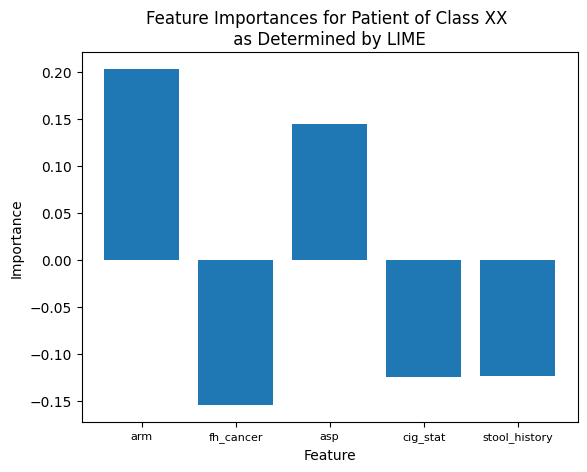

In [ ]:
# Print out LIME Results
labels = [x[0] for x in exp.as_list()]
print(labels)
# label_interp = ['Treatment \n Days', 'Diagnosis \n Days', 'Days Until \n Treatment', 'FSG Exam','Right Side \n Adenoma']
label_interp = ['Worst Finding Right \n Side Adenoma', 'Days Until \n Endoscopy', 'Size Largest \n Adenoma', 'Left Side \n Adenoma','Days Until \n Diagnosis']

values = [x[1] for x in exp.as_list()]

plt.bar(labels, values)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances for Patient of Class XX \n as Determined by LIME ')
plt.xticks(fontsize='8')
plt.show()